# C247 Final Project - EEG
-   Date: Mar 15th

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers, optimizers

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
%cd C:\Users\QGY51\Desktop\C247\project

C:\Users\QGY51\Desktop\C247\project


In [4]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

In [5]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Decoding and Visualizing

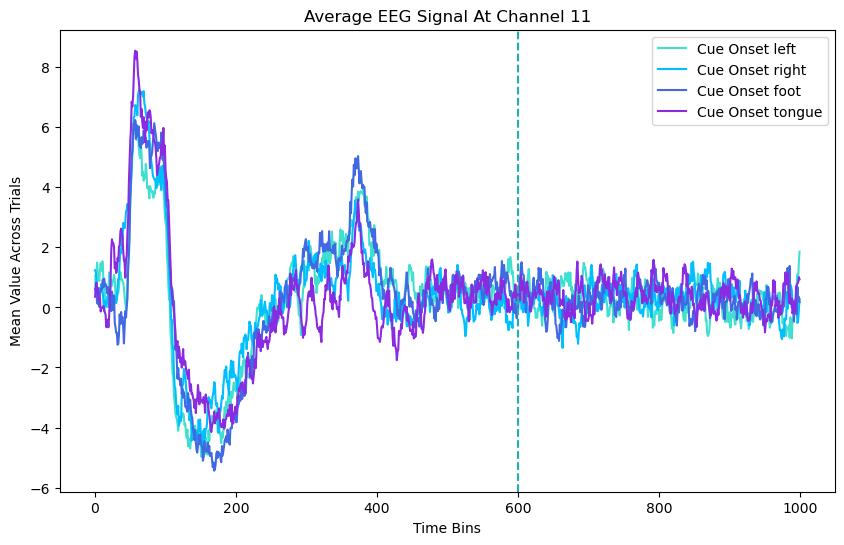

In [6]:
## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,11,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot each class with a cool color
plt.plot(np.arange(1000), avg_ch_data_class_0, color='turquoise', label="Cue Onset Left")
plt.plot(np.arange(1000), avg_ch_data_class_1, color='deepskyblue', label="Cue Onset Right")
plt.plot(np.arange(1000), avg_ch_data_class_2, color='royalblue', label="Cue Onset Foot")
plt.plot(np.arange(1000), avg_ch_data_class_3, color='blueviolet', label="Cue Onset Tongue")

plt.axvline(x=600, label='Cue Onset', c='lightseagreen', linestyle='--')  # Make the cue onset line in a cool color

plt.title("Average EEG Signal At Channel 11")

plt.xlabel("Time Bins")
plt.ylabel("Mean Value Across Trials")


plt.legend(["Cue Onset left", "Cue Onset right", "Cue Onset foot", "Cue Onset tongue"])
plt.show()

## Data Processing

In [8]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,600)
    X = X[:,:,0:600]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,600)
    X = X[:,:,0:600]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X


########################################################################

def segment_data_by_subject(x_test, y_test, person_test):
    x_test_by_subject = defaultdict(list)
    y_test_by_subject = defaultdict(list)

    for i, subject_id_array in enumerate(person_test):
        subject_id = int(subject_id_array[0])
        x_test_by_subject[subject_id].append(x_test[i])
        y_test_by_subject[subject_id].append(y_test[i])

    for subject_id in x_test_by_subject:
        x_test_by_subject[subject_id] = np.array(x_test_by_subject[subject_id])
        y_test_by_subject[subject_id] = np.array(y_test_by_subject[subject_id])

    return x_test_by_subject, y_test_by_subject


def evaluate_and_plot(model, x_test_by_subject, y_test_by_subject):
    subject_accuracies = {}

    for subject_id in sorted(x_test_by_subject.keys()):
        x_test_subject = x_test_by_subject[subject_id]
        y_test_subject = y_test_by_subject[subject_id]
        
        test_loss, test_accuracy = model.evaluate(x_test_subject, y_test_subject, verbose=0)
        subject_accuracies[subject_id] = test_accuracy
        
        print(f"Subject {subject_id + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    subject_ids = [subject_id + 1 for subject_id in sorted(subject_accuracies)]
    accuracies = [subject_accuracies[subject_id] for subject_id in sorted(subject_accuracies)]

    plt.figure(figsize=(10, 6))
    plt.bar(subject_ids, accuracies, color='skyblue')
    plt.xlabel('Subject ID', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Model Accuracy by Subject', fontsize=16)
    plt.xticks(subject_ids)
    plt.ylim(0, 1)

    for i, acc in enumerate(accuracies):
        plt.text(subject_ids[i], acc, f"{acc:.2f}", ha='center', va='bottom')

    plt.show()



def prepare_training_data_for_subject(X, y, person_train, subject_id=0, sub_sample=2, average=2, noise=True):

    x_train_by_subject, y_train_by_subject = segment_data_by_subject(X, y, person_train)


    x_train_subject = x_train_by_subject[subject_id]
    y_train_subject = y_train_by_subject[subject_id]
    

    x_train_prepared, y_train_prepared = train_data_prep(x_train_subject, y_train_subject, sub_sample, average, noise)
    
    return x_train_prepared, y_train_prepared


In [9]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 


## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1000, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification


y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

if y_test.ndim == 1 or y_test.shape[1] != 4:
    y_test = to_categorical(y_test, 4)
    
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


#Subject based
print('############################')

x_train_valid_sub1, y_train_valid_sub1 = prepare_training_data_for_subject(X_train_valid, y_train_valid, person_train_valid)

x_test_by_subject, y_test_by_subject = segment_data_by_subject(x_test, y_test, person_test)


num_samples = len(x_train_valid_sub1)  # Total number of samples after preprocessing
num_validation_samples = int(1000/8460 * num_samples)  # 20% of the total number of samples

ind_valid_sub1 = np.random.choice(num_samples, num_validation_samples, replace=False)
ind_train_sub1 = np.array(list(set(range(len(x_train_valid_sub1))).difference(set(ind_valid_sub1))))

x_train_sub1 = x_train_valid_sub1[ind_train_sub1]
y_train_sub1 = y_train_valid_sub1[ind_train_sub1]
x_valid_sub1 = x_train_valid_sub1[ind_valid_sub1]
y_valid_sub1 = y_train_valid_sub1[ind_valid_sub1]

y_train_sub1 = to_categorical(y_train_sub1, 4)
y_valid_sub1 = to_categorical(y_valid_sub1, 4)

x_train_sub1 = x_train_sub1.reshape(x_train_sub1.shape[0], x_train_sub1.shape[1], x_train_sub1.shape[2], 1)
x_valid_sub1 = x_valid_sub1.reshape(x_valid_sub1.shape[0], x_valid_sub1.shape[1], x_valid_sub1.shape[2], 1)

x_train_sub1 = np.swapaxes(x_train_sub1, 1, 3)
x_train_sub1 = np.swapaxes(x_train_sub1, 1, 2)
x_valid_sub1 = np.swapaxes(x_valid_sub1, 1, 3)
x_valid_sub1 = np.swapaxes(x_valid_sub1, 1, 2)

print('Shape of subject 1 training set:', x_train_sub1.shape)
print('Shape of subject 1 validation set:', x_valid_sub1.shape)
print('Shape of subject 1 training labels:', y_train_sub1.shape)
print('Shape of subject 1 validation labels:', y_valid_sub1.shape)


Shape of X after trimming: (2115, 22, 600)
Shape of X after maxpooling: (2115, 22, 300)
Shape of X after averaging+noise and concatenating: (4230, 22, 300)
Shape of X after subsampling and concatenating: (8460, 22, 300)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 600)
Shape of X after maxpooling: (443, 22, 300)
Shape of training set: (7460, 22, 300)
Shape of validation set: (1000, 22, 300)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 300, 1)
Shape of validation set after adding width info: (1000, 22, 300, 1)
Shape of test set after adding width info: (443, 22, 300, 1)
Shape of training set after dimension reshaping: (7460, 300, 1, 22)
Shape of validation set after dimension reshaping: (1000, 300, 1, 22)

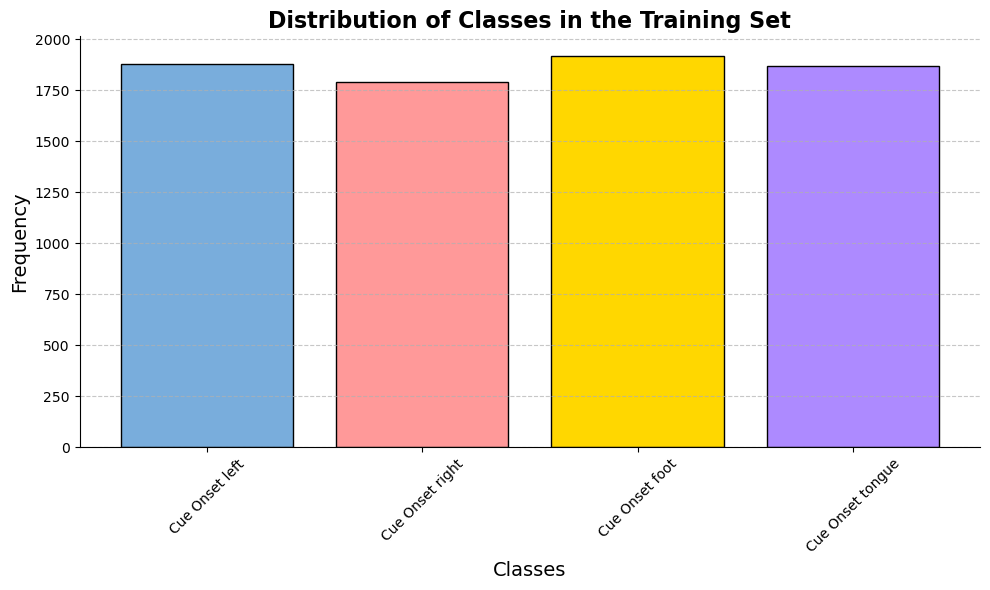

In [10]:
class_counts = np.sum(y_train, axis=0)
class_list = ["Cue Onset left", "Cue Onset right", "Cue Onset foot", "Cue Onset tongue"]

plt.figure(figsize=(10, 6))

colors = ['#79addc', '#ff9999', '#ffd700', '#ad8aff']

plt.bar(class_list, class_counts, color=colors, edgecolor='black')
plt.title('Distribution of Classes in the Training Set', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

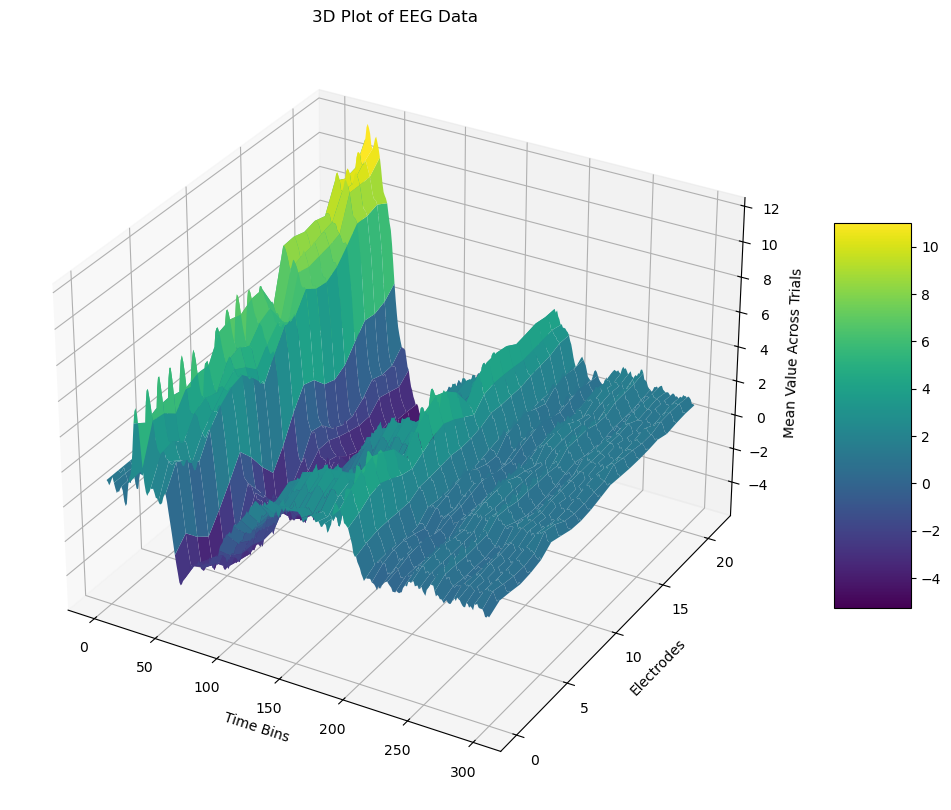

In [11]:
x_train_reduced = np.squeeze(x_train, axis=2)

mean_across_trials = np.mean(x_train_reduced, axis=0)

time_bins = np.arange(300)  
electrodes = np.arange(22)   # Y axis - 22 electrodes

T, E = np.meshgrid(time_bins, electrodes)

# Create a 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotting
# Transpose mean_across_trials to match the shape of T and E
surf = ax.plot_surface(T, E, mean_across_trials.T, cmap='viridis', edgecolor='none')

ax.set_xlabel('Time Bins')
ax.set_ylabel('Electrodes')
ax.set_zlabel('Mean Value Across Trials')
ax.set_title('3D Plot of EEG Data')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## 1D Model

### Shaping Input

In [10]:
# Reducing the shape by removing the dimension with size 1
x_train_reduced = np.squeeze(x_train, axis=2)
x_valid_reduced = np.squeeze(x_valid, axis=2)
x_test_reduced = np.squeeze(x_test, axis=2) 



####

x_train_sub1_reduced = np.squeeze(x_train_sub1, axis=2)
x_valid_sub1_reduced = np.squeeze(x_valid_sub1, axis=2)


x_test_reduced_by_subject = {}
for subject_id, x_data in x_test_by_subject.items():
    
    x_test_reduced_by_subject[subject_id] = np.squeeze(x_data, axis=2)


print('Shape of training set after reduction:', x_train_reduced.shape)
print('Shape of validation set after reduction:', x_valid_reduced.shape)
print('Shape of testing set after reduction:', x_test_reduced.shape)

Shape of training set after reduction: (7460, 300, 22)
Shape of validation set after reduction: (1000, 300, 22)
Shape of testing set after reduction: (443, 300, 22)


### CNN Model

In [13]:
def model_cnn_1d(input_shape, num_classes):
    l2_reg = regularizers.l2(0.001)
    model = models.Sequential([
        layers.Conv1D(32, 5, activation='elu', input_shape=input_shape, padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling1D(3, padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  

        layers.Conv1D(64, 5, activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling1D(3, padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  

        layers.Conv1D(128, 5, activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling1D(3, padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  

        layers.Conv1D(256, 5, activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling1D(3, padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  

        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


input_shape = (600//2, 22)  
num_classes = 4


model= model_cnn_1d(input_shape, num_classes)

learning_rate = 1e-3
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

history = model.fit(x_train_reduced, y_train, batch_size=64, epochs=100, validation_data=(x_valid_reduced, y_valid), verbose=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 300, 32)           3552      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 34, 64)           0

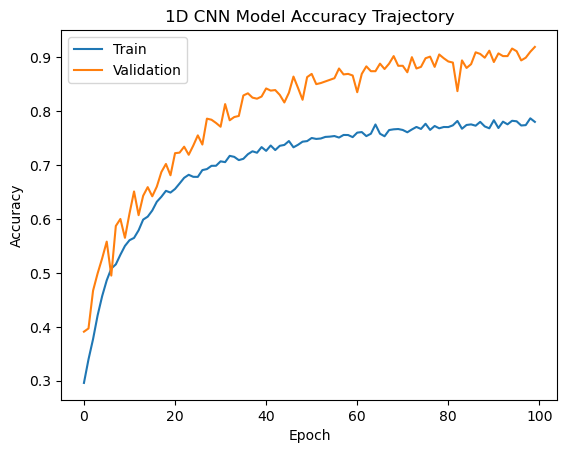

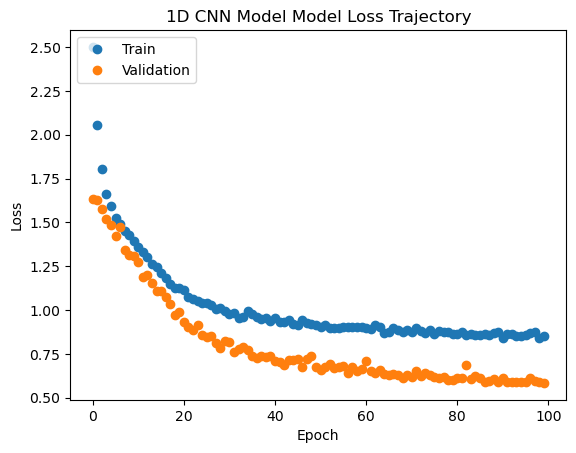

14/14 [==============================] - 0s 3ms/step - loss: 1.0073 - accuracy: 0.7043
Test Loss: 1.0073120594024658
Test Accuracy: 0.7042889595031738


In [14]:
# Plotting accuracy trajectory
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('1D CNN Model Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'], 'o')
plt.plot(history.history['val_loss'], 'o')
plt.title('1D CNN Model Model Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the whole model
test_loss, test_accuracy = model.evaluate(x_test_reduced, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Subject 1 - Test Loss: 1.0808, Test Accuracy: 0.6600
Subject 2 - Test Loss: 1.1898, Test Accuracy: 0.5800
Subject 3 - Test Loss: 0.6881, Test Accuracy: 0.8800
Subject 4 - Test Loss: 0.9340, Test Accuracy: 0.7800
Subject 5 - Test Loss: 0.9693, Test Accuracy: 0.7021
Subject 6 - Test Loss: 1.1008, Test Accuracy: 0.6939
Subject 7 - Test Loss: 1.0703, Test Accuracy: 0.7200
Subject 8 - Test Loss: 0.9212, Test Accuracy: 0.7400
Subject 9 - Test Loss: 0.9209, Test Accuracy: 0.7234


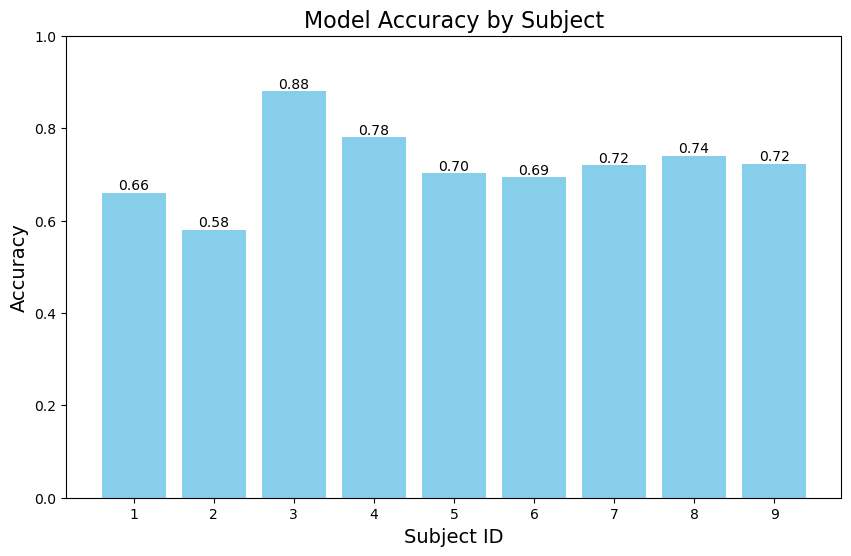

In [19]:
####Testing

evaluate_and_plot(model, x_test_reduced_by_subject, y_test_by_subject)

## 2D model

### CNN Model

In [13]:
def model_cnn_2d(input_shape, num_classes):
    l2_reg = regularizers.l2(0.001)  # L2 regularization factor
    model = models.Sequential([
        # Convolutional Block 1
        layers.Conv2D(32, (5, 5), activation='elu', input_shape=input_shape, padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D((3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        # Convolutional Block 2
        layers.Conv2D(64, (5, 5), activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D((3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        # Convolutional Block 3
        layers.Conv2D(128, (5, 5), activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D((3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        # Convolutional Block 4
        layers.Conv2D(256, (5, 5), activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D((3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        layers.Flatten(),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


input_shape = (600//2, 1, 22)  
num_classes = 4  


model = model_cnn_2d(input_shape, num_classes)


learning_rate = 1e-3
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()


history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_valid, y_valid), verbose=True)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 300, 1, 32)        17632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 1, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 100, 1, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 100, 1, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 1, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 1, 64)       

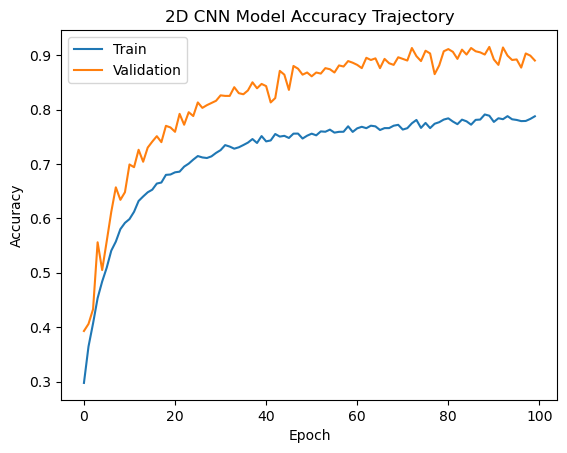

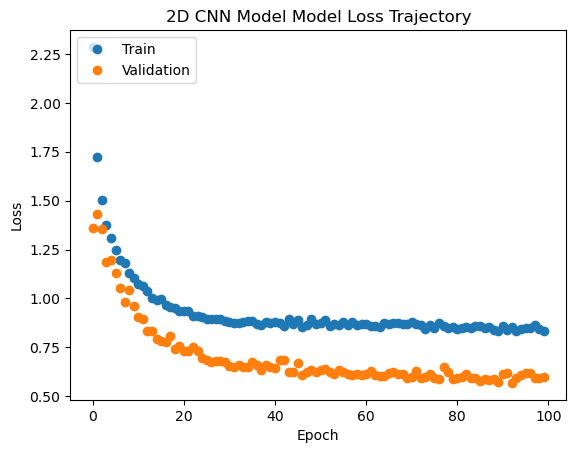

14/14 [==============================] - 0s 7ms/step - loss: 0.9675 - accuracy: 0.7223
Test Loss: 0.9675366282463074
Test Accuracy: 0.722347617149353


In [14]:
# Plotting accuracy trajectory
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('2D CNN Model Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'], 'o')
plt.plot(history.history['val_loss'], 'o')
plt.title('2D CNN Model Model Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the whole model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Subject 1 - Test Loss: 1.0214, Test Accuracy: 0.6800
Subject 2 - Test Loss: 1.1494, Test Accuracy: 0.6200
Subject 3 - Test Loss: 0.7564, Test Accuracy: 0.7800
Subject 4 - Test Loss: 0.9449, Test Accuracy: 0.7800
Subject 5 - Test Loss: 1.0143, Test Accuracy: 0.7021
Subject 6 - Test Loss: 1.0669, Test Accuracy: 0.6939
Subject 7 - Test Loss: 1.0275, Test Accuracy: 0.7600
Subject 8 - Test Loss: 0.8853, Test Accuracy: 0.7200
Subject 9 - Test Loss: 0.8389, Test Accuracy: 0.7660


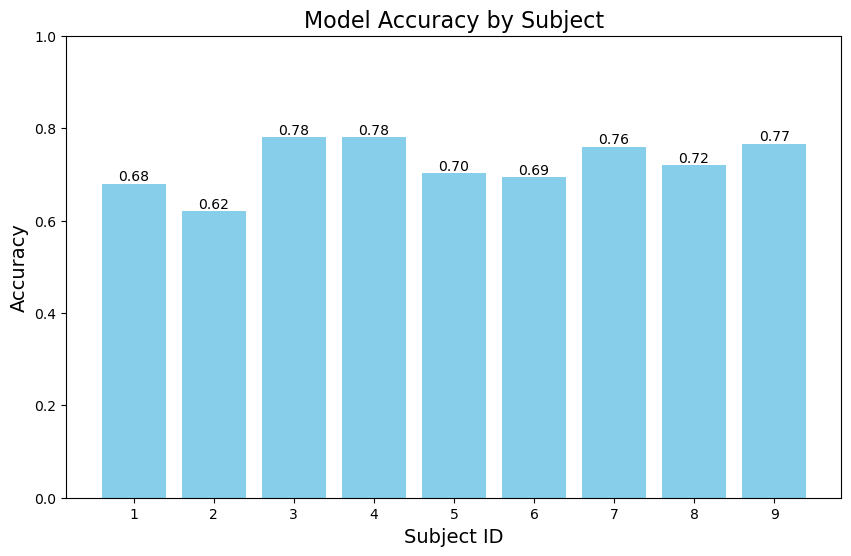

In [15]:
####Testing

evaluate_and_plot(model, x_test_by_subject, y_test_by_subject)

## For Subject 1 Optimization

In [10]:
def model_cnn_2d(input_shape, num_classes):
    l2_reg = regularizers.l2(0.001)  # L2 regularization factor
    model = models.Sequential([
        # Convolutional Block 1
        layers.Conv2D(128, (5, 5), activation='elu', input_shape=input_shape, padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D((3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        # Convolutional Block 2
        layers.Conv2D(256, (5, 5), activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D((3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        # Convolutional Block 3
        layers.Conv2D(512, (5, 5), activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D((3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        # Convolutional Block 4
        layers.Conv2D(1024, (5, 5), activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D((3, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),

        layers.Flatten(),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


input_shape = (600//2, 1, 22)  
num_classes = 4  


model = model_cnn_2d(input_shape, num_classes)

learning_rate = 1e-3
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

history = model.fit(x_train_sub1, y_train_sub1, batch_size=64, epochs=100, validation_data=(x_valid_sub1, y_valid_sub1), verbose=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 1, 128)       70528     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 1, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 1, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100, 1, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 1, 256)       819456    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 1, 256)       0

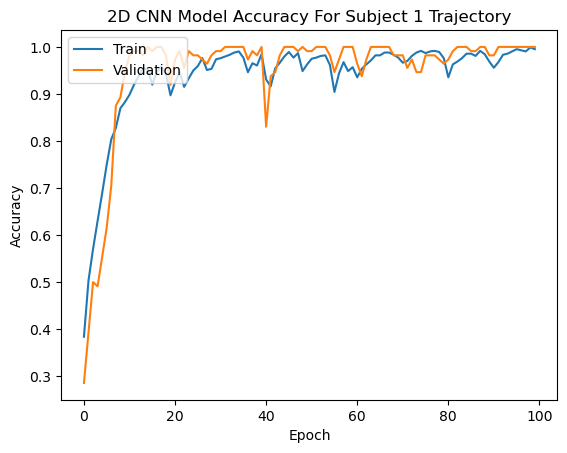

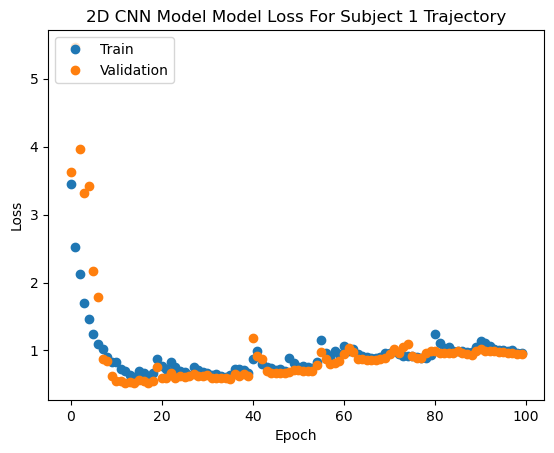

14/14 [==============================] - 0s 11ms/step - loss: 8.0570 - accuracy: 0.4289
Test Loss: 8.05698299407959
Test Accuracy: 0.42889389395713806


In [11]:
# Plotting accuracy trajectory
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('2D CNN Model Accuracy For Subject 1 Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'], 'o')
plt.plot(history.history['val_loss'], 'o')
plt.title('2D CNN Model Model Loss For Subject 1 Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the whole model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test label shape: (443, 4)
Subject 1 - Test Loss: 4.3142, Test Accuracy: 0.6400
Subject 2 - Test Loss: 7.6303, Test Accuracy: 0.3600
Subject 3 - Test Loss: 3.3618, Test Accuracy: 0.6400
Subject 4 - Test Loss: 7.5134, Test Accuracy: 0.3400
Subject 5 - Test Loss: 12.0089, Test Accuracy: 0.3191
Subject 6 - Test Loss: 10.7056, Test Accuracy: 0.2653
Subject 7 - Test Loss: 8.7655, Test Accuracy: 0.4400
Subject 8 - Test Loss: 9.9603, Test Accuracy: 0.4400
Subject 9 - Test Loss: 8.5740, Test Accuracy: 0.4043


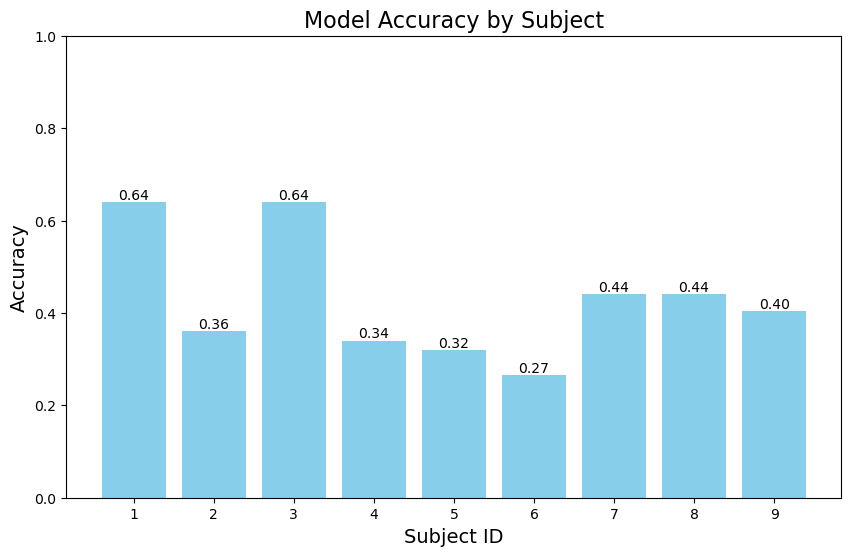

In [12]:
####Testing

# Verify test label shape
print("Test label shape:", y_test.shape)

evaluate_and_plot(model, x_test_by_subject, y_test_by_subject)

In [19]:
def model_cnn_1d(input_shape, num_classes):
    l2_reg = regularizers.l2(0.001)
    model = models.Sequential([
        layers.Conv1D(32, 5, activation='elu', input_shape=input_shape, padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling1D(3, padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  

        layers.Conv1D(64, 5, activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling1D(3, padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  

        layers.Conv1D(128, 5, activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling1D(3, padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  

        layers.Conv1D(256, 5, activation='elu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling1D(3, padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  

        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (600//2, 22)  
num_classes = 4


model= model_cnn_1d(input_shape, num_classes)


learning_rate = 1e-3
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

history = model.fit(x_train_sub1_reduced, 
                    y_train_sub1, 
                    batch_size=64, 
                    epochs=100, 
                    validation_data=(x_valid_sub1_reduced, y_valid_sub1), 
                    verbose=True)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 300, 32)           3552      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 100, 32)          0         
 g1D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 100, 32)          128       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 100, 32)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 100, 64)           10304     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 34, 64)          

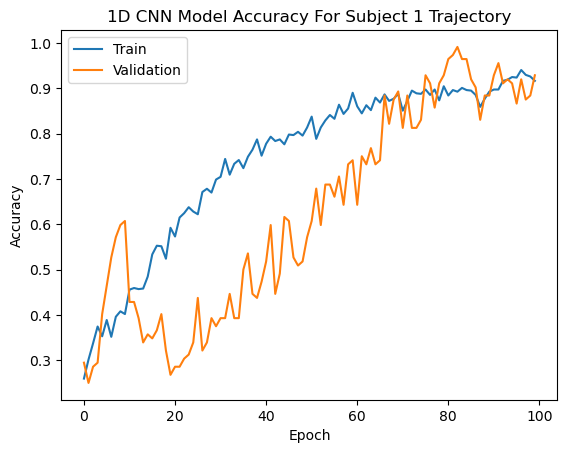

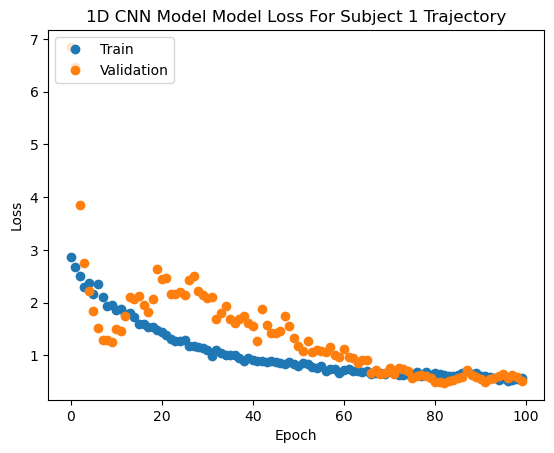

14/14 [==============================] - 0s 8ms/step - loss: 4.3056 - accuracy: 0.4018
Test Loss: 4.305618762969971
Test Accuracy: 0.4018058776855469


In [20]:
# Plotting accuracy trajectory
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('1D CNN Model Accuracy For Subject 1 Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'], 'o')
plt.plot(history.history['val_loss'], 'o')
plt.title('1D CNN Model Model Loss For Subject 1 Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the whole model
test_loss, test_accuracy = model.evaluate(x_test_reduced, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test label shape: (443, 4)
Subject 1 - Test Loss: 2.2218, Test Accuracy: 0.6400
Subject 2 - Test Loss: 4.4703, Test Accuracy: 0.3600
Subject 3 - Test Loss: 1.5400, Test Accuracy: 0.6000
Subject 4 - Test Loss: 4.9261, Test Accuracy: 0.3400
Subject 5 - Test Loss: 7.5067, Test Accuracy: 0.2766
Subject 6 - Test Loss: 4.5575, Test Accuracy: 0.3061
Subject 7 - Test Loss: 5.0581, Test Accuracy: 0.3600
Subject 8 - Test Loss: 3.7516, Test Accuracy: 0.4000
Subject 9 - Test Loss: 4.9545, Test Accuracy: 0.3191


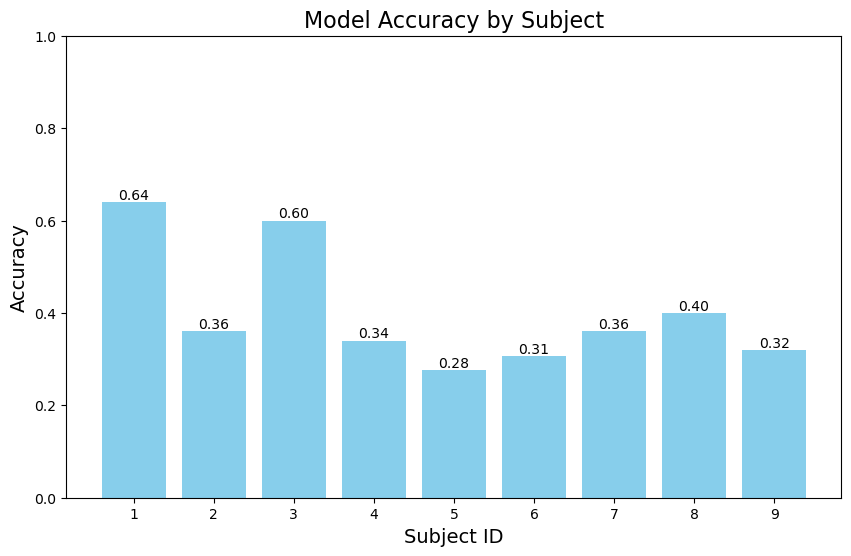

In [21]:
####Testing

# Verify test label shape
print("Test label shape:", y_test.shape)

evaluate_and_plot(model, x_test_reduced_by_subject, y_test_by_subject)

## Simple Testing on Other Models

In [13]:
def model_rcnn_2d_complex(input_shape, num_classes):
    l2 = regularizers.l2(0.001)  # L2 regularization factor
    model = models.Sequential([
        layers.Conv2D(128, (10, 1), activation='elu', input_shape=input_shape, kernel_regularizer=l2, padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 1)),
        layers.Dropout(0.2),

        layers.Conv2D(256, (10, 1), activation='elu', kernel_regularizer=l2, padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 1)),
        layers.Dropout(0.2),

        layers.Conv2D(512, (10, 1), activation='elu', kernel_regularizer=l2, padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 1)),
        layers.Dropout(0.2),

        layers.Conv2D(1024, (10, 1), activation='elu', kernel_regularizer=l2, padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 1)),
        layers.Dropout(0.2),

        layers.Flatten(),

        layers.Reshape((-1, 1024)),  # Adjust based on the actual output

        layers.Bidirectional(layers.GRU(256, return_sequences=True, kernel_regularizer=l2)),
        layers.Dropout(0.5),
        layers.Bidirectional(layers.GRU(128, kernel_regularizer=l2)),
        layers.Dropout(0.5),

        layers.Dense(256, activation='elu', kernel_regularizer=l2),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


input_shape = (600//2, 1, 22)  
num_classes = 4  

input_shape = (600//2, 1, 22)  
num_classes = 4  


model = model_rcnn_2d_complex(input_shape, num_classes)


learning_rate = 1e-3
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_valid, y_valid), verbose=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 300, 1, 128)       28288     
                                                                 
 batch_normalization_4 (Batc  (None, 300, 1, 128)      512       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 150, 1, 128)      0         
 ooling2D)                                                       
                                                                 
 dropout_4 (Dropout)         (None, 150, 1, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 1, 256)       327936    
                                                                 
 batch_normalization_5 (Batc  (None, 150, 1, 256)     

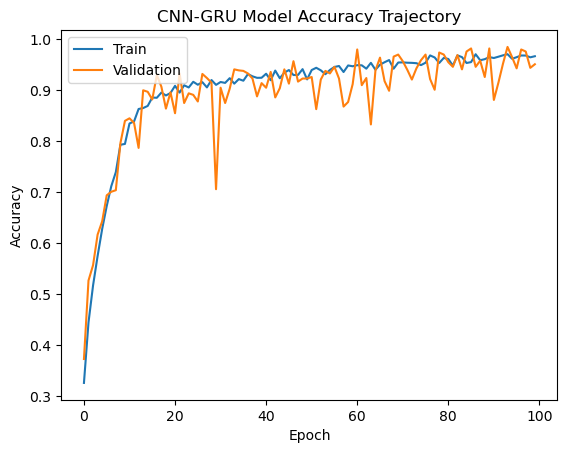

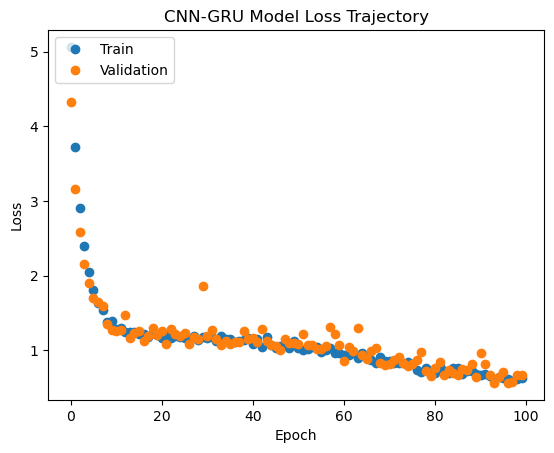

14/14 [==============================] - 1s 25ms/step - loss: 2.0617 - accuracy: 0.6637
Test Loss: 2.061727285385132
Test Accuracy: 0.6636568903923035


In [14]:
# Plotting accuracy trajectory
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN-GRU Model Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'], 'o')
plt.plot(history.history['val_loss'], 'o')
plt.title('CNN-GRU Model Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test label shape: (443, 4)
Subject 1 - Test Loss: 2.2510, Test Accuracy: 0.6000
Subject 2 - Test Loss: 2.7536, Test Accuracy: 0.4800
Subject 3 - Test Loss: 1.7268, Test Accuracy: 0.7000
Subject 4 - Test Loss: 2.1888, Test Accuracy: 0.6400
Subject 5 - Test Loss: 1.7327, Test Accuracy: 0.7234
Subject 6 - Test Loss: 1.9764, Test Accuracy: 0.6939
Subject 7 - Test Loss: 2.0160, Test Accuracy: 0.7200
Subject 8 - Test Loss: 2.0192, Test Accuracy: 0.7600
Subject 9 - Test Loss: 1.8573, Test Accuracy: 0.6596


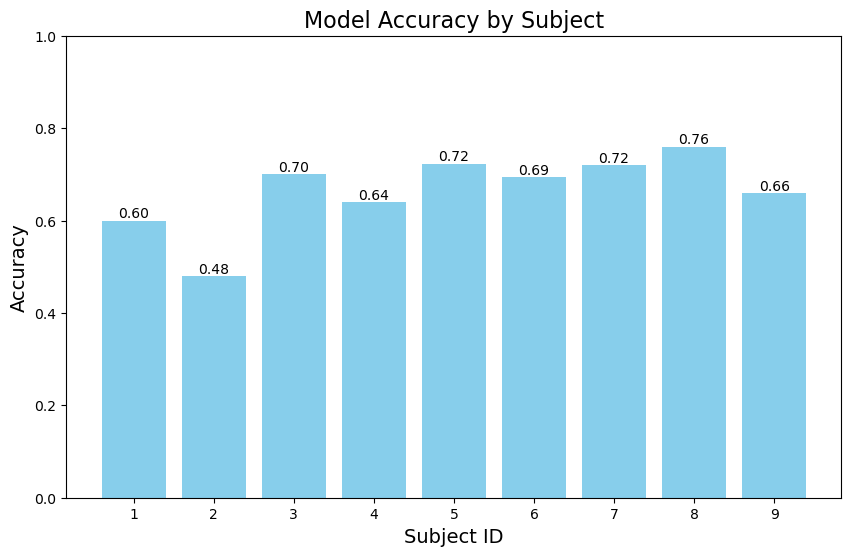

In [15]:
####Testing

# Verify test label shape
print("Test label shape:", y_test.shape)

evaluate_and_plot(model, x_test_by_subject, y_test_by_subject)